#Attention mechanism based Deep Neural Networks for robust breast cancer identification from mammography images

#Imports


In [26]:
# General Libraries
import os
import shutil
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from io import BytesIO
from PIL import Image
import IPython.display as display
from imageio import imread
from skimage.transform import resize
import cv2

# Set seaborn style
sns.set()

# Machine Learning Libraries
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.utils import shuffle, compute_class_weight
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, Xception, MobileNet, NASNetMobile, DenseNet169, DenseNet121, MobileNetV2, InceptionV3, EfficientNetB0, EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Other Imports
import skimage


# Importing DataSet (Once Per Session)


In [2]:
# # Content Folder is Ephemeral ( Do This Once Per Session only)

# from google.colab import drive
# drive.mount('/content/drive')
# ! mkdir -p /content/.kaggle
# !cp /content/drive/MyDrive/KaggleAPI/kaggle.json /content/.kaggle
# ! chmod 600 /content/.kaggle/kaggle.json
# !kaggle datasets download -d skooch/ddsm-mammography -p /content
# !unzip /content/ddsm-mammography.zip -d /content/DataSet


Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/skooch/ddsm-mammography
License(s): CC0-1.0
100% 2.88G/2.88G [02:25<00:00, 20.9MB/s]
100% 2.88G/2.88G [02:25<00:00, 21.2MB/s]
Archive:  /content/ddsm-mammography.zip
  inflating: /content/DataSet/cv10_data/cv10_data.npy  
  inflating: /content/DataSet/cv10_labels.npy  
  inflating: /content/DataSet/test10_data/test10_data.npy  
  inflating: /content/DataSet/test10_labels.npy  
  inflating: /content/DataSet/training10_0/training10_0.tfrecords  
  inflating: /content/DataSet/training10_1/training10_1.tfrecords  
  inflating: /content/DataSet/training10_2/training10_2.tfrecords  
  inflating: /content/DataSet/training10_3/training10_3.tfrecords  
  inflating: /content/DataSet/training10_4/training10_4.tfrecords  


# Extracting Dataset
##(Execute this only Once Per Runtime)


In [6]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

# label_normal    : normal / abnormal
# label           : multi class classfication


def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))


    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())


filenames=['/content/DataSet/training10_0/training10_0.tfrecords',
          '/content/DataSet/training10_1/training10_1.tfrecords',
          '/content/DataSet/training10_2/training10_2.tfrecords',
          '/content/DataSet/training10_3/training10_3.tfrecords',
          '/content/DataSet/training10_4/training10_4.tfrecords'
          ]

for file in filenames:
    read_data(file)

print(len(images))
print(len(labels))


# -----------------------------------------------------------
# Extracting Images to Separate Folders



# Paths to save the images
train_dir = '/content/train_data/'
val_dir = '/content/val_data/'

# Create directories for training and validation data
for directory in [train_dir, val_dir]:
    for label in ['normal', 'abnormal']:
        os.makedirs(os.path.join(directory, label), exist_ok=True)

# Split the images into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42)

# Save the training images
for idx, image in enumerate(train_images):
    label = 'normal' if train_labels[idx] == 0 else 'abnormal'
    file_path = os.path.join(train_dir, label, f'image_{idx}.png')
    cv2.imwrite(file_path, image)

# Save the validation images
for idx, image in enumerate(val_images):
    label = 'normal' if val_labels[idx] == 0 else 'abnormal'
    file_path = os.path.join(val_dir, label, f'image_{idx}.png')
    cv2.imwrite(file_path, image)

#EDA




# Image Data Overview and Shape Statistics



In [11]:
print(f"Total images: {len(images)}")
print(f"Image shape: {np.array(images[0]).shape}")  # Check the shape of one image

# Check for unique image shapes (for consistency check)
shapes = [img.shape for img in images]
unique_shapes = set(shapes)
print(f"Unique image shapes: {unique_shapes}")


Total images: 55885
Image shape: (100, 100, 3)
Unique image shapes: {(100, 100, 3)}


#  Check Image Pixel Value Range:


In [12]:
#  Check Image Pixel Value Range:
# Check the pixel value range in one sample image
print("Min pixel value:", np.min(images[0]))
print("Max pixel value:", np.max(images[0]))


Min pixel value: 80
Max pixel value: 155


# Check the datatype of the images


In [13]:
# Check the datatype of the images
print("Data type of the image:", images[0].dtype)


Data type of the image: uint8


#Visualize a few  images

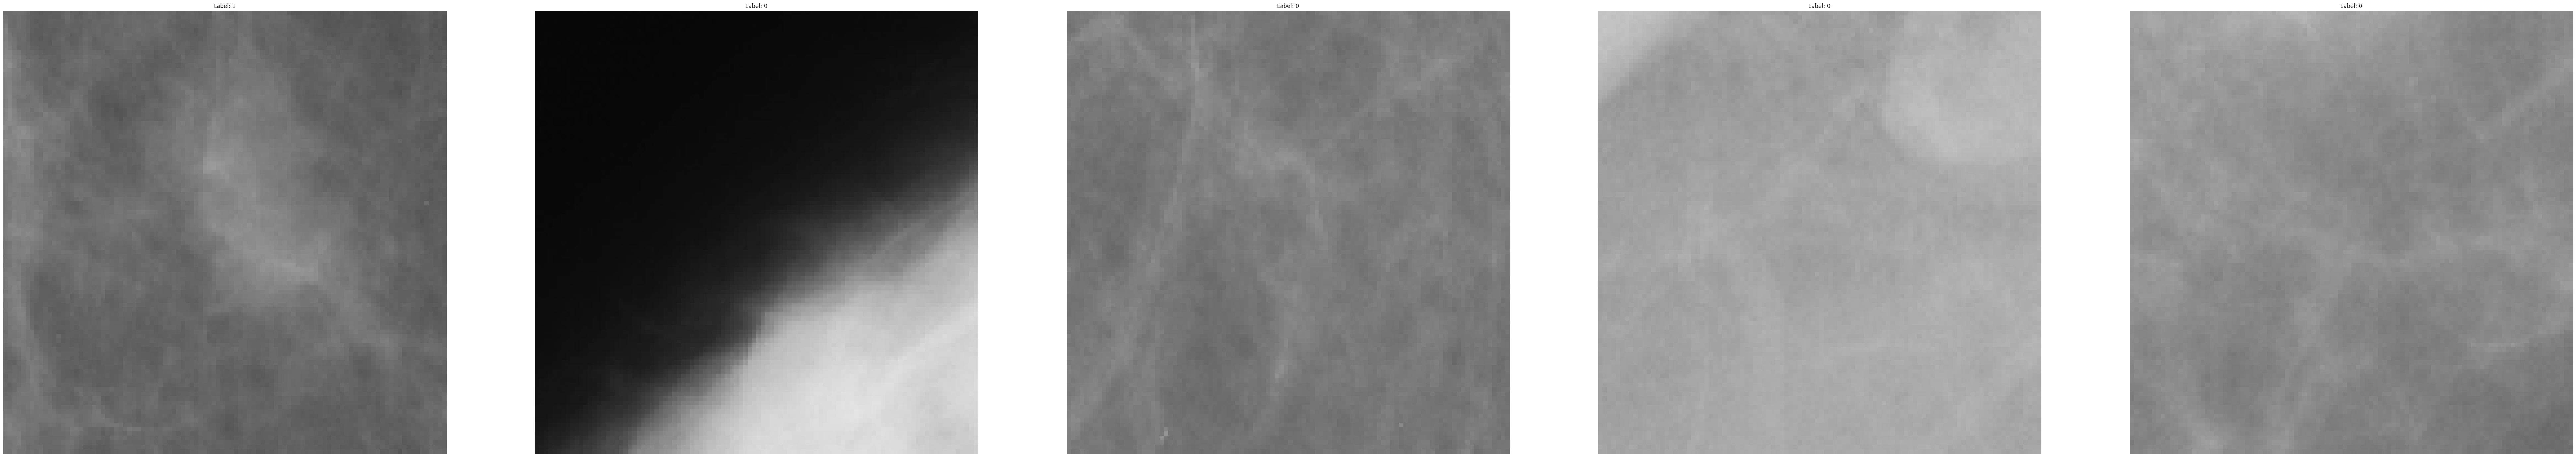

In [23]:
# Plot some sample images from both classes


def plot_sample_images(images, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(100, 100))
    for i in range(num_samples):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

# Plot 5 random images
plot_sample_images(images, labels)


#Pixel Intensity Distribution

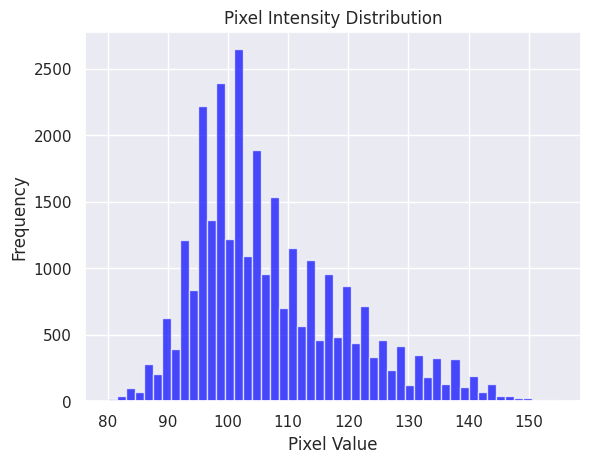

In [16]:
# Flatten an image to check the pixel distribution
flattened_image = images[0].flatten()

# Plot the distribution of pixel values
plt.hist(flattened_image, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


##Class Distribution


In [14]:
# Count the distribution of binary labels (normal/abnormal)
label_normal_distribution = Counter(labels)
print("Binary class distribution (label_normal):", label_normal_distribution)

Binary class distribution (label_normal): Counter({0: 48596, 1: 7289})


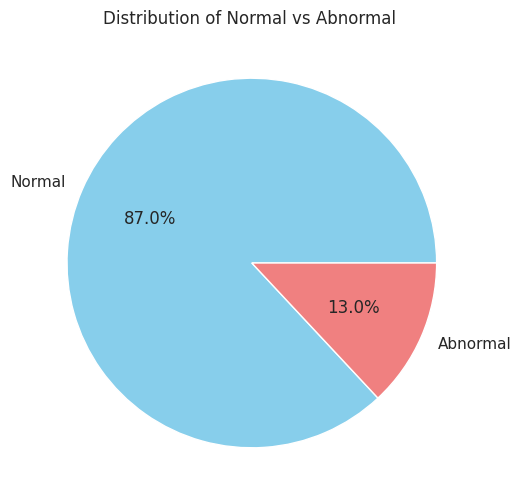

In [17]:
# Count the occurrences of each class
class_counts = np.bincount(labels)

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=['Normal', 'Abnormal'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Normal vs Abnormal ')
plt.show()

#Pixel Value Distribution
###The pixel intensity range for medical images is essential for understanding contrast and brightness.
###Visualizing pixel value distributions across a few sample images can help identify any irregularities.

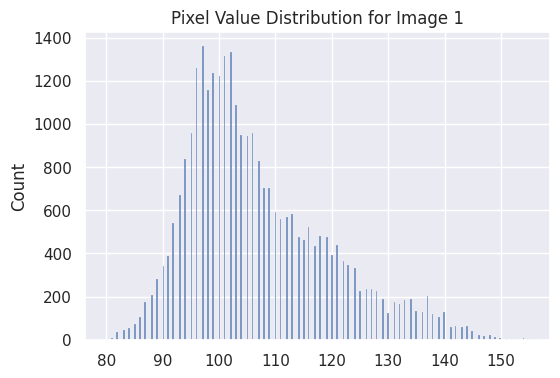

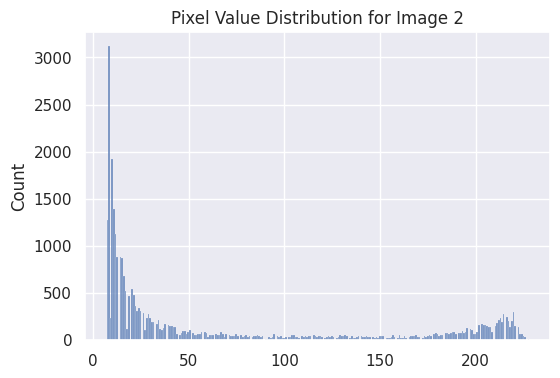

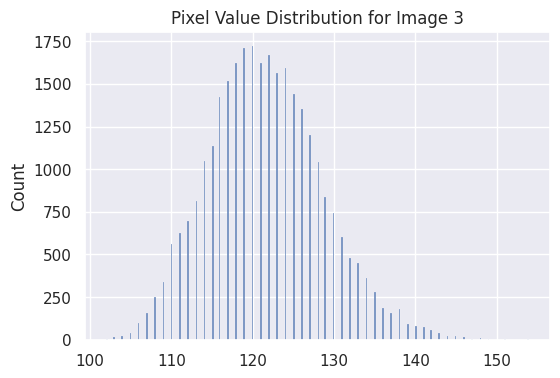

In [18]:
for i in range(3):  # Check for 3 random images
    plt.figure(figsize=(6, 4))
    sns.histplot(images[i].ravel(), bins=256, kde=False)
    plt.title(f'Pixel Value Distribution for Image {i+1}')
    plt.show()


#Image Visualization (RGB and Grayscale)
#### A quick look at a few images in both grayscale and RGB format will help understand their visual quality and consistency.


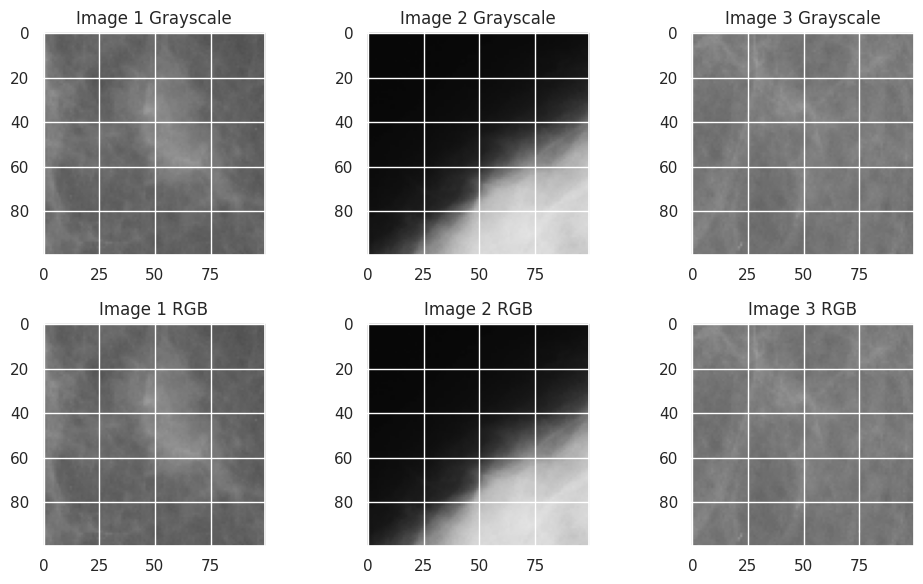

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for i in range(3):
    ax[0, i].imshow(images[i], cmap='gray')  # Grayscale visualization
    ax[0, i].set_title(f'Image {i+1} Grayscale')
    ax[1, i].imshow(images[i])  # RGB visualization
    ax[1, i].set_title(f'Image {i+1} RGB')
plt.tight_layout()
plt.show()


# Visualize a few positive and negative examples

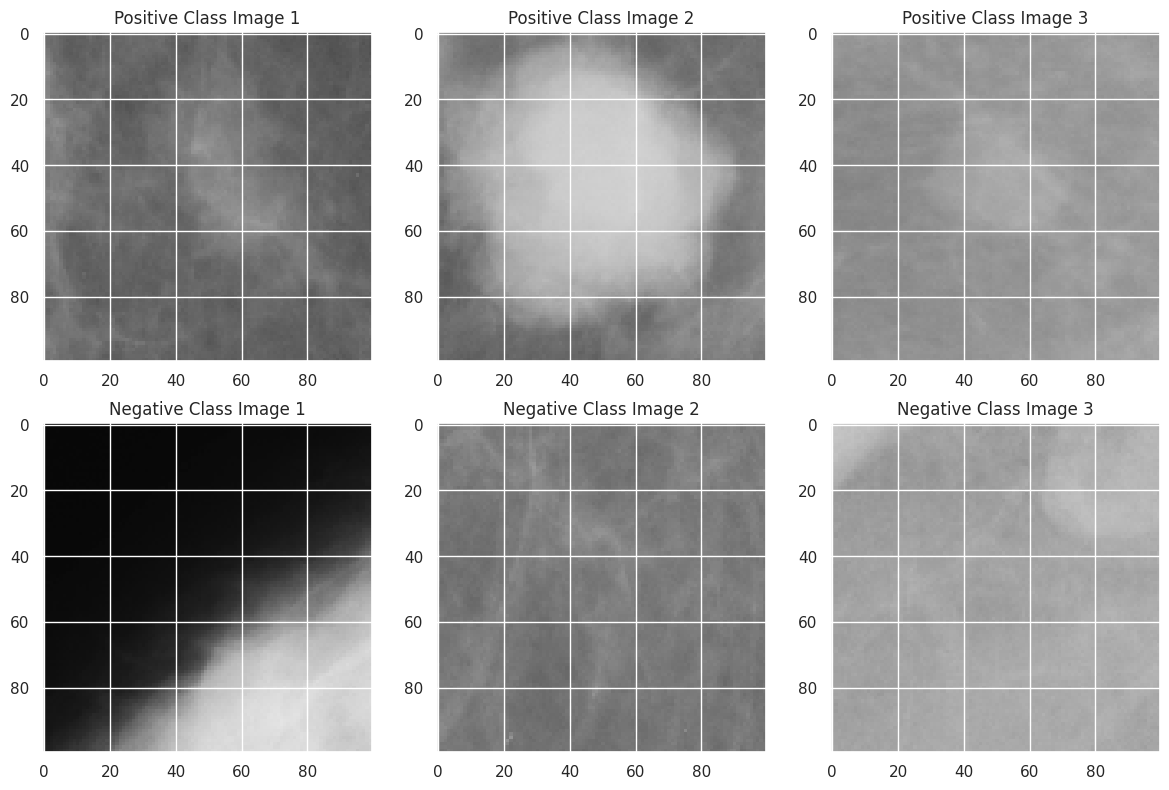

In [20]:
pos_images = [img for img, label in zip(images, labels) if label == 1][:3]
neg_images = [img for img, label in zip(images, labels) if label == 0][:3]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for i in range(3):
    ax[0, i].imshow(pos_images[i])
    ax[0, i].set_title(f'Positive Class Image {i+1}')
    ax[1, i].imshow(neg_images[i])
    ax[1, i].set_title(f'Negative Class Image {i+1}')
plt.tight_layout()
plt.show()


# Statistical Summary of Pixel Values


In [21]:

pixel_means = [np.mean(img) for img in images]
pixel_stds = [np.std(img) for img in images]

print(f"Average pixel mean: {np.mean(pixel_means)}")
print(f"Average pixel std deviation: {np.mean(pixel_stds)}")


Average pixel mean: 91.28047676299545
Average pixel std deviation: 20.72216976488008


#PCA of Image Features

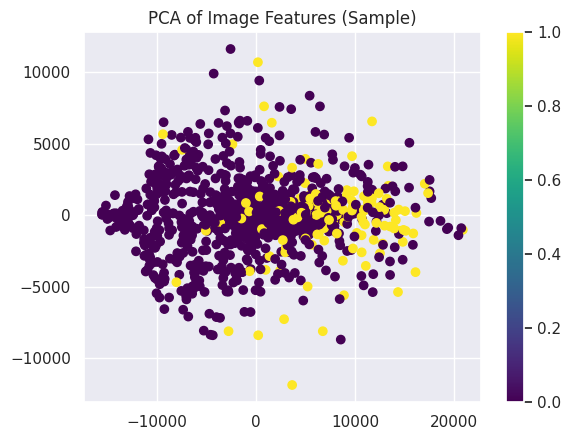

In [22]:
from sklearn.decomposition import PCA

# Subset of 1000 images for PCA (assuming images is a list of numpy arrays)
sample_images = np.array([img.flatten() for img in images[:1000]])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_images)

# Visualize the PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels[:1000], cmap='viridis')
plt.title('PCA of Image Features (Sample)')
plt.colorbar()
plt.show()


#Setting Data Augmentation Image Generators

### Key Augmentations Included:


...



In [ ]:
# Function to add Gaussian noise
def add_gaussian_noise(image):
    noise = np.random.normal(0, 0.05, image.shape)  # Adjust noise parameters as needed
    noisy_image = image + noise
    return np.clip(noisy_image, 0., 1.)  # Ensure pixel values remain in [0, 1]


# Set up the data generators
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
    # preprocessing_function=add_gaussian_noise  # Add Gaussian noise
)



# Training data generator
train_generator = datagen.flow_from_directory(
    train_dir,                    # Folder with your training images
    target_size=(224, 224),        # VGG16 expects 224x224 images
    batch_size=32,                 # Adjust batch size according to memory
    class_mode='binary',           # Binary classification (normal/abnormal)
    subset='training'              # Training data
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    val_dir,                      # Folder with your validation images
    target_size=(224, 224),        # VGG16 expects 224x224 images
    batch_size=32,                 # Adjust batch size according to memory
    class_mode='binary',           # Binary classification (normal/abnormal)
    subset='validation'            # Validation data
)


## Set up callbacks


In [ ]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

#Model Training


#### VGG-16 Model Training and Test


In [ ]:
# VGG16 Model with Adam optimizer

# Load the VGG-16 model, exclude the top layers
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add custom top layers
x = Flatten()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)# Binary classification, so use sigmoid

# Define the final model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=output)

# Compile the model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on the validation set
val_loss_vgg16, val_accuracy_vgg16 = model_vgg16.evaluate(validation_generator)
print(f'VGG16 - Validation Loss: {val_loss_vgg16}')
print(f'VGG16 - Validation Accuracy: {val_accuracy_vgg16}')


Epoch 1/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 504s 447ms/step - accuracy: 0.8573 - loss: 0.9256 - val_accuracy: 0.8966 - val_loss: 0.2560 - learning_rate: 0.0010
Epoch 2/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 501s 447ms/step - accuracy: 0.8981 - loss: 0.2590 - val_accuracy: 0.9011 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 3/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 489s 435ms/step - accuracy: 0.8978 - loss: 0.2531 - val_accuracy: 0.9011 - val_loss: 0.2626 - learning_rate: 0.0010
Epoch 4/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 501s 435ms/step - accuracy: 0.9002 - loss: 0.2413 - val_accuracy: 0.9069 - val_loss: 0.2266 - learning_rate: 0.0010
Epoch 5/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 500s 445ms/step - accuracy: 0.9046 - loss: 0.2395 - val_accuracy: 0.9056 - val_loss: 0.2224 - learning_rate: 0.0010
Epoch 6/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 494s 437ms/step - accuracy: 0.9105 - loss: 0.2241 - val_accuracy: 0.9167 - val_loss: 0.2193 - learning_rate: 0.0010
Epoch 7/30
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 508s 443ms

#### VGG-19 Model Training and Test


In [ ]:
# VGG19 Model with Adam optimizer

# Load the VGG-19 model, exclude the top layers
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG19
for layer in base_model_vgg19.layers:
    layer.trainable = False

# Add custom top layers
x = Flatten()(base_model_vgg19.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the final model
model_vgg19 = Model(inputs=base_model_vgg19.input, outputs=output)

# Compile the model
model_vgg19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg19 = model_vgg19.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on the validation set
val_loss_vgg19, val_accuracy_vgg19 = model_vgg19.evaluate(validation_generator)
print(f'VGG19 - Validation Loss: {val_loss_vgg19}')
print(f'VGG19 - Validation Accuracy: {val_accuracy_vgg19}')


#### Res-Net50 Model Training and Test


In [ ]:
# ResNet50 Model  with Nadam optimizer

# Load the ResNet50 model, exclude the top layers
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of ResNet50
for layer in base_model_resnet50.layers:
    layer.trainable = False

# Add custom top layers
x = Flatten()(base_model_resnet50.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the final model
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=output)

# Compile the model
model_resnet50.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet50 = model_resnet50.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on the validation set
val_loss_resnet50, val_accuracy_resnet50 = model_resnet50.evaluate(validation_generator)
print(f'ResNet50 - Validation Loss: {val_loss_resnet50}')
print(f'ResNet50 - Validation Accuracy: {val_accuracy_resnet50}')


#### EfficientNetB0 Model Training and Test


In [ ]:
# EfficientNetB0 Model with Nadam optimizer

# Load the EfficientNetB0 model, exclude the top layers
base_model_efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of EfficientNetB0
for layer in base_model_efficientnetb0.layers:
    layer.trainable = False

# Add custom top layers
x = Flatten()(base_model_efficientnetb0.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the final model
model_efficientnetb0 = Model(inputs=base_model_efficientnetb0.input, outputs=output)

# Compile the model
model_efficientnetb0.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_efficientnetb0 = model_efficientnetb0.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on the validation set
val_loss_efficientnetb0, val_accuracy_efficientnetb0 = model_efficientnetb0.evaluate(validation_generator)
print(f'EfficientNetB0 - Validation Loss: {val_loss_efficientnetb0}')
print(f'EfficientNetB0 - Validation Accuracy: {val_accuracy_efficientnetb0}')


#### EfficientNetB1 Model Training and Test


In [ ]:
# EfficientNetB1 Model  with Nadam optimizer

# Load the EfficientNetB1 model, exclude the top layers
base_model_efficientnetb1 = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of EfficientNetB1
for layer in base_model_efficientnetb1.layers:
    layer.trainable = False

# Add custom top layers
x = Flatten()(base_model_efficientnetb1.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the final model
model_efficientnetb1 = Model(inputs=base_model_efficientnetb1.input, outputs=output)

# Compile the model
model_efficientnetb1.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_efficientnetb1 = model_efficientnetb1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on the validation set
val_loss_efficientnetb1, val_accuracy_efficientnetb1 = model_efficientnetb1.evaluate(validation_generator)
print(f'EfficientNetB1 - Validation Loss: {val_loss_efficientnetb1}')
print(f'EfficientNetB1 - Validation Accuracy: {val_accuracy_efficientnetb1}')


#Testing and training  Graphs

In [ ]:
# Plot the training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
plot_training_history(history_vgg16)
plot_training_history(history_vgg19)
plot_training_history(history_resnet50)
plot_training_history(history_efficientnetb0)
plot_training_history(history_efficientnetb1)

#Model Evaluation


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Function to evaluate model performance
def evaluate_model_performance(model, validation_generator):
    # Predict the validation set results
    y_pred_prob = model.predict(validation_generator)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary output (threshold at 0.5)

    # Get the true labels from the validation generator
    y_true = validation_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print precision, recall, and F1-score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Classification report for more details
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred))


In [ ]:
# Evaluate VGG16
evaluate_model_performance(model_vgg16, validation_generator)

In [ ]:
# Evaluate VGG19
evaluate_model_performance(model_vgg19, validation_generator)

In [ ]:
# Evaluate ResNet50
evaluate_model_performance(model_resnet50, validation_generator)


In [ ]:
# Evaluate EfficientNetB0
evaluate_model_performance(model_efficientnetb0, validation_generator)


In [ ]:
# Evaluate EfficientNetB1
evaluate_model_performance(model_efficientnetb1, validation_generator)

In [ ]:
# Final test accuracy and loss for each model
def final_test_evaluation(model, validation_generator):
    test_loss, test_accuracy = model.evaluate(validation_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Test evaluations
final_test_evaluation(model_vgg16, validation_generator)
final_test_evaluation(model_vgg19, validation_generator)
final_test_evaluation(model_resnet50, validation_generator)
final_test_evaluation(model_efficientnetb0, validation_generator)
final_test_evaluation(model_efficientnetb1, validation_generator)
